## Introduction

Typically a neural network will use a loss function and optimize the weights towards minimizing the value of the loss function. However, we wanted to explore the possibilties of using Genetic Algorithms to optimize weight vectors in a neural network for use in predictive models for real world application like the one used in the project, automated market trading. 

The baseline for this project is the same neural network model ran with the same initializer as our first generation of our Genetic Algorithm. The first generation of our Genetic Algorithm is essentially a unmodified neural network as the weights are defaulted to being random and we seeded our intializer for a form of consistency. 

We decided to use the first generation as our baseline because we wanted to see if our optimization technique could perform better than the default optimization of optimizing the MSE loss function.

What we are attempting to substitute the baseline optimization for is a Genetic Algorithm. A Genetic Algorithm, or GA, is a optimization technique based on the principles of natural selection and genetics. GA's follow the same cycle of natural selection: An initial random population, Selection based on measured fitness, Survival and Termination, Reproduction based on the survived specimens, mutation and genetic crossover of parents to create children, and then the cycle continues.


## Data Set

The data was chosen purely for accessibility and abundancy which is why we went with data from the yfinance python library. We decided on using Apples market trading data because it's data was consistent within the last 5 years. The data extened further back than 5 years but we decided to cut it off after 5 years because of performance concerns. 

The yfinance library provided more datasets than just Apple's market trading data which meant we could use another companies dataset like AMD to test our optimization attempts. 

## Genetic Algorithm Implementation

In [48]:
import tensorflow as tf
import numpy as np
import yfinance as yf
import random

### Data Class

Simple class used to help process the data retrieved from yfinance library. We are defaulting to the Apple stock data by specifying the Apple ticker value of 'APPL'. Later we will use AMD stock data by specifying the AMD ticker value of 'AMD'. 

In [49]:
class Data:
    def __init__(self, ticker='AAPL'):
        self.data = yf.download(ticker, period='5y', interval='1d')
        self.current_index = 0

    def get_current_price(self):
        if self.current_index < len(self.data):
            return self.data.iloc[self.current_index]['Close']
        else:
            return None

    def get_tensor(self):
        end_index = self.current_index + 1
        start_index = max(0, end_index - 15)
        return np.array(self.data.iloc[start_index:end_index])

    def next(self):
        if self.current_index < len(self.data) - 1:
            self.current_index += 1
        else:
            self.current_index = 0


### Brain Class

The brain class is used to surround our neural network. We used defaulted parameters taken from the notebook on neural networks with keras because we wanted stable parameters to test against our Genetic Alorithm. It is a simple class that helps abstract pulling the weights from the neural network. Our prediction method is just to help us format the input and output. 

In [50]:
class Brain:
    def __init__(self):
        self.model = tf.keras.Sequential()
        initializer = tf.keras.initializers.RandomUniform(minval=-.5, maxval=.5, seed=42)
        # Define a model with 10 output neurons corresponding to binary classification tasks
        self.model.add(tf.keras.layers.Dense(80, activation='relu', input_shape=(75,), kernel_initializer=initializer))
        self.model.add(tf.keras.layers.Dense(10, activation='sigmoid', kernel_initializer=initializer))
        self.model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mse'])

    def prediction(self, inputs):

        inputs_np = np.array(inputs).reshape(1, -1)
        pred = self.model.predict(inputs_np, verbose=0)

        binary_outputs = (pred >= 0.5).astype(int)
        
        x, y = binary_outputs[0, 0], binary_outputs[0, 1]

        binary_string = ''.join(str(bit) for bit in binary_outputs[0, 2:])
        decimal_value = int(binary_string, 2)

        z = decimal_value / 255

        return [x, y, z]

    def set_weights(self, weights):
        self.model.set_weights(weights)

    def get_weights(self):
        return self.model.get_weights()

### Agent Class

This class is the host for the Brain. It holds all the logic for defining buy, sell, and hold vectors. It serves as the lowest level stock trading interface of our genetic algorithm. It holds a single instantiation of data from the Data class for all the agents to look at simultaneously.


In [51]:
class Agent:

    data = Data()
    id = 0

    def __init__(self):
        self.id = Agent.id
        Agent.id = Agent.id + 1
        self.returns = 0
        self.fitness = 0
        self.input_dimension = 75
        self.row_dimension = 5
        self.row_data = Agent.data.get_tensor()[0] # numpy array of length 6

        temp = []
        for i in range(self.row_dimension):
            temp.append(self.row_data[i])
        for _ in range(self.input_dimension - self.row_dimension):
            temp.append(0)

        self.inputs = temp # python list of length 75
        self.current_price = self.inputs[0]
        self.brain = Brain()
        self.predictions = self.brain.prediction(self.inputs) # returns [{0, 1}, {0, 1}, float_between(0, 1)]
        self.active_trades = []

    def __lt__(self, other):
        if self.returns < other.returns:
            return True
        else:
            return False

    def make_trades(self):
        if self.predictions[0] > 0.5:
            if self.predictions[1] > 0.5:
                self.buy(self.current_price * (1 + self.predictions[2]))
            else:
                self.sell(self.current_price * (1 - self.predictions[2]))

    def buy(self, target):
        if target > self.inputs[0] * 1.10:
            self.fitness -= 10
        else:
            self.active_trades.append([target, 2*self.current_price - target, target - self.current_price, 1])

    def sell(self, target):
        if target < self.inputs[0] * 0.9:
            self.fitness -= 10
        else:
            self.active_trades.append([target, 2*self.current_price - target, self.current_price - target, 0])

    def close_trades(self):
        to_keep = []
        # print(f"Active Trades: {self.active_trades}")
        for trade in self.active_trades:
            if trade[3] == 1:
                if trade[0] <= self.current_price:
                    self.returns += trade[2]
                elif trade[1] >= self.current_price:
                    self.returns -= trade[2]
                else:
                    to_keep.append(trade)
            else:
                if trade[0] >= self.current_price:
                    self.returns += trade[2]
                elif trade[1] <= self.current_price:
                    self.returns -= trade[2]
                else:
                    to_keep.append(trade)
        self.active_trades = to_keep
        # print(f"Active Trades: {self.active_trades}")

    def force_close_trades(self):
        clear = []
        for trade in self.active_trades:
            open = (trade[0] + trade[1]) / 2
            if trade[3] == 1:
                self.returns += self.current_price - open
            else:
                self.returns += open - self.current_price
        self.active_trades = clear

    def get_next_inputs(self):
    # goes to next day, and appends the new data to inputs
        self.data.next()
        self.row_data = Agent.data.get_tensor()[0]
        for i in range(self.row_dimension):
            self.inputs.insert(0, self.row_data[i])
            self.inputs.pop()
        self.current_price = self.inputs[0]
        self.predictions = self.brain.prediction(self.inputs)

    def cycle(self):
        self.close_trades()
        self.make_trades()
        self.get_next_inputs()

[*********************100%%**********************]  1 of 1 completed


### Gen Class

This class serves as the main driver for our Genetic Algorithm. Holds all of the logic perataining to the evolution driven design of a Genetic Algorithm. We designed it to take a dynamic population size and number of generations so we could test what we could get away with in terms of performance as our computation was a very limiting factor. Another peformance factor was the window of data we decided to pass in. In the simulate function, we run each agent for two months worth of data because we believe 60 days of trading is a good amount of data to balance the performance of our algorithm.

In [52]:
class Gen:
    to_graph = []

    def __init__(self, population_size, generations, mutation_rate=0.25):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

    def crossover(self, parent1, parent2):
        child = Agent()
        p1_weights = parent1.brain.get_weights()
        p2_weights = parent2.brain.get_weights()
        new_weights = []
    
        for p1_layer, p2_layer in zip(p1_weights, p2_weights):
            if len(p1_layer.shape) == 1:  # This means the layer is one-dimensional (biases)
                gene_cutoff = np.random.randint(0, p1_layer.size)
                new_gene = np.concatenate([p1_layer[:gene_cutoff], p2_layer[gene_cutoff:]])
            else:  # This means the layer is two-dimensional (weights)
                gene_cutoff = np.random.randint(0, p1_layer.size)
                new_gene = np.concatenate([p1_layer[:gene_cutoff], p2_layer[gene_cutoff:]])
    
            new_weights.append(new_gene)

        child.brain.set_weights(new_weights)
        return child
    
    def mutate(self, agent):
        weights = agent.brain.get_weights()
        mutated_weights = []
        for weight in weights:
            if np.random.rand() < self.mutation_rate:
                mutation_matrix = np.random.uniform(-0.1, 0.1, weight.shape)
                weight += mutation_matrix
            mutated_weights.append(weight)
        agent.brain.set_weights(mutated_weights)

    def simulate(self):
        NUM_MONTHS = 2
        agents = []
        for _ in range(self.population_size):
            agent = Agent()
            agents.append(agent)
        for generation in range(self.generations):
            for agent in agents:
                for i in range(NUM_MONTHS * 30):
                    agent.cycle()
                agent.force_close_trades()
                print(f"Agent {agent.id}'s returns after {i + 1} cycles: {agent.returns:.2f}")
            ranked_agents = sorted(agents)
            ranked_agents.reverse()
            print(f"=== Gen {generation} ===\n Best: ${ranked_agents[0].returns:.2f}. Worst: ${ranked_agents[-1].returns:.2f}")
            Gen.to_graph.append(ranked_agents[0].returns)
            elites = ranked_agents[:len(ranked_agents) // 2]
            new_generation = []
            for _ in range(int(self.population_size * 0.8)):
                child = self.crossover(random.choice(elites), random.choice(elites))
                self.mutate(child)
                new_generation.append(child)
            for i in range(int(self.population_size * 0.2)):
                elites[i].returns = 0
                new_generation.append(elites[i])

            agents = new_generation
        return ranked_agents[0]

## Output 

It is simple to run our code, simply call Gen() constructor with the population size and number of generations to run, then call simulate on the choses parameters. It also has an optional parameter for mutation rate.

After it is run, it will return the weight vector of the agent that performed the best.

In [53]:
Agent.id = 0
test = Gen(15, 5)
best_agent = test.simulate()

data_to_test = 200
test_data = Data('AMD')
Agent.data = test_data
first_brain_agent = Agent()
best_agent.returns = 0
first_brain_agent.returns = 0
 
for _ in range(data_to_test):
    best_agent.cycle()
    first_brain_agent.cycle()
best_agent.force_close_trades()
first_brain_agent.force_close_trades()
print(f"best_agent's returns after {data_to_test} cycles: {best_agent.returns}")
print(f"first_brain_agent's returns after {data_to_test} cycles: {first_brain_agent.returns}")

Agent 0's returns after 60 cycles: 6.45
Agent 1's returns after 60 cycles: -47.78
Agent 2's returns after 60 cycles: -132.07
Agent 3's returns after 60 cycles: 62.93
Agent 4's returns after 60 cycles: -133.30
Agent 5's returns after 60 cycles: -99.20
Agent 6's returns after 60 cycles: -9.22
Agent 7's returns after 60 cycles: 56.22
Agent 8's returns after 60 cycles: 44.26
Agent 9's returns after 60 cycles: -234.28
Agent 10's returns after 60 cycles: -170.88
Agent 11's returns after 60 cycles: 170.27
Agent 12's returns after 60 cycles: 135.82
Agent 13's returns after 60 cycles: -173.26
Agent 14's returns after 60 cycles: 29.37
=== Gen 0 ===
 Best: $170.27. Worst: $-234.28
Agent 15's returns after 60 cycles: 19.84
Agent 16's returns after 60 cycles: -210.22
Agent 17's returns after 60 cycles: -328.02
Agent 18's returns after 60 cycles: 2.82
Agent 19's returns after 60 cycles: -75.10
Agent 20's returns after 60 cycles: 196.12
Agent 21's returns after 60 cycles: -1.15
Agent 22's returns aft

[*********************100%%**********************]  1 of 1 completed


best_agent's returns after 200 cycles: -77.04247162762805
first_brain_agent's returns after 200 cycles: -55.212703405642


## Conclusion

According to our baseline our final evolution of weights is worse compared to our base line. This could have happened for a number a reasons. The main reason is that this outcome occured is that we did not have the hardware, both personal and school available without access to the 400 lab computers, to run a effective sample size to get a better fitted outcome. 

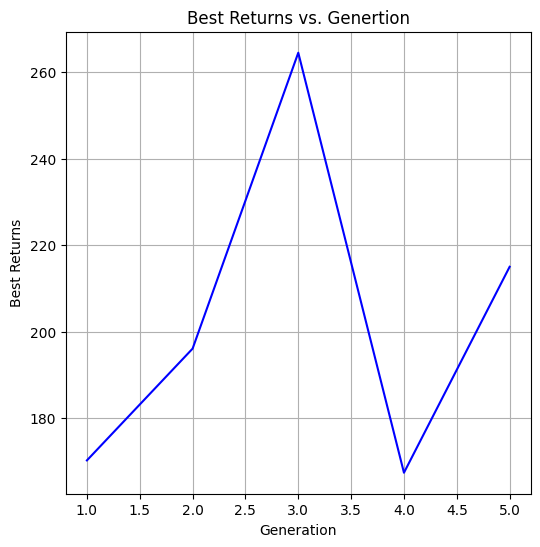

In [54]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(6, 6))
plt.plot([1,2,3,4,5], Gen.to_graph, color='blue')
plt.title('Best Returns vs. Genertion')
plt.xlabel('Generation')
plt.ylabel('Best Returns')
plt.grid(True)
plt.show()

The graph above shows the the returns from the best neural network, using the weights derived from our genetic algorithm, from each generation. We predict that the returns would continue grow over a higher generation and population set. 

We knew in advance that our outcome might not be optimal nor the one we were hoping to achieve due to the low number of population and generations.


## Reflection

After numerous iterations of our genetic algorithm we still wanted to do things differently but unfortunatly had the deadline creep up faster than expected: 

* The population seeding is not accessible from the agent class which forces the first populations to have all the same random weights which delays the rate at which the weight vector evolves. 

* We could have implemented a period where we stop buying and wait to sell for profit so we dont have to force close trades. This is counter productive because it could have been skewing returns into the negative. 